# Assignment 2


**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


## Group

* Luca Babboni - luca.babboni2@studio.unibo.it
* Matteo Fasulo - matteo.fasulo@studio.unibo.it
* Maksim Omelchenko - maksim.omelchenko@studio.unibo.it
* Luca Tedeschini - luca.tedeschini3@studio.unibo.it



## Description

This notebook addresses [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.


## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the binary classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

### Libraries
In order to excecute the code we are gonna install and import the necessary libraries.
First of all we are gonna install the last version of bitsandbytes in order to been able to use the quantization.

In [ ]:
%%capture
%pip install -U bitsandbytes

Then we need to reload the notebook kernel

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  # Restart the kernel

{'status': 'ok', 'restart': True}

Finally we are able to import the required libraries

In [ ]:
import pandas as pd
from pathlib import Path
import requests
import os
import re
import random
from copy import deepcopy
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [ ]:
!huggingface-cli loginn


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `Deleteme` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `Deleteme`


After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

In [ ]:
def download_corpus(url: str, filename: str) -> None:
    """
    Downloads a text corpus from a given URL and saves it to a specified filename within the data folder if not exist

    Args:
        url (str): The URL from which to download the corpus.
        filename (str): The name of the file to save the downloaded corpus.

    Raises:
        requests.exceptions.HTTPError: If the HTTP request returned an unsuccessful status code.

    Side Effects:
        Creates the data folder if it does not exist.
        Writes the downloaded corpus to the specified file.
    """
    data_folder = Path("./data")
    if not data_folder.exists():
      data_folder.mkdir(parents=True)
      print(f"Created folder {data_folder}.")

    if not (data_folder / filename).exists():
      response = requests.get(url)
      response.raise_for_status()
      with open(data_folder / filename, 'w', encoding='utf-8') as f:
        f.write(response.text)
      print(f"Created file {data_folder / filename}.")
    else:
      print(f"File {data_folder / filename} already exists.")

In [ ]:
path_test = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/a2_test.csv'
path_demonstrations = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/demonstrations.csv'

In [ ]:
download_corpus(path_test, 'a2_test.csv')
download_corpus(path_demonstrations, 'demonstrations.csv')

Created folder data.
Created file data/a2_test.csv.
Created file data/demonstrations.csv.


In [ ]:
df = pd.read_csv('./data/a2_test.csv', encoding='utf-8')
df.head()

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,not sexist
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,sexist
2,sexism2022_english-3018,Old man mogs everyone in this sub,not sexist
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",not sexist
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,sexist


# Model 1 - Mistral V3 7B
As first model we are gonna analyze the performance of Mistral V3

## Task 1 - Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware


In [ ]:
def load_model(model_card):
    """
    Loads a pre-trained model and its tokenizer with 8-bit quantization.

    Args:
        model_card (str): The identifier of the pre-trained model to load.

    Returns:
        tuple: A tuple containing the quantized model and the tokenizer.
            - model_8bit (transformers.PreTrainedModel): The quantized model loaded in 8-bit precision.
            - tokenizer (transformers.PreTrainedTokenizer): The tokenizer associated with the model.
    """
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    tokenizer = AutoTokenizer.from_pretrained(model_card)
    model_8bit = AutoModelForCausalLM.from_pretrained(model_card, quantization_config=quantization_config)
    model_8bit.eval()
    return model_8bit, tokenizer

In [ ]:
model_card = 'mistralai/Mistral-7B-Instruct-v0.3'
model_8bit, tokenizer = load_model(model_card)

device = model_8bit.device
print(f'Model loaded on {device}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model loaded on cuda:0


## Task 2 - Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


**Prompt Template**

Use the following prompt template to process input texts.

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

**Instructions**

In order to get Task 2 points, we require you to:

* Write the ``prepare_prompts`` function

In [ ]:
def prepare_prompts(texts, prompt_template, tokenizer, device):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """
  prompts = []
  for text in texts:
    prompt_with_text = deepcopy(prompt_template)
    # add text
    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)

    prompts.append(tokenizer.apply_chat_template(prompt_with_text, tokenize=True,
                                                 add_generation_prompt=True,
                                                 return_dict=True,
                                                 return_tensors="pt").to(device))

  return prompts

In [ ]:
prompts = prepare_prompts(df['text'], prompt, tokenizer, device=device)

print("Prompt example: \n")
print(tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True))

Prompt example: 

You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        


## Task 3 - Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

**Instructions**

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [ ]:
def generate_responses(model, prompt_examples):
  """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples

    Outputs:
      generated responses
  """
  answers = []
  for prompt in tqdm(prompt_examples):
    response = model.generate(**prompt, max_new_tokens=1000, pad_token_id=tokenizer.eos_token_id)
    answers.append(response)
  return answers

In [ ]:
def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed binary response: return 1 if YES and 0 if NO
  """
  response = tokenizer.decode(response[0])
  if 'YES' in response.split('ANSWER')[-1]:
    return 1
  else:
    return 0

In [ ]:
def get_generated_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to extract only the text generated by the LLM.

    Inputs:
      response: generated response from LLM

    Outputs:
      LLM generated text: string
  """
  response = tokenizer.decode(response[0])
  response = response.split('[/INST]')[-1]
  cleaned_string = re.sub(r'</s>', '', response).strip()
  return cleaned_string

In [ ]:
answers = generate_responses(model_8bit, prompts)

100%|██████████| 300/300 [03:55<00:00,  1.27it/s]


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

In [ ]:
original_labels = [1 if label == 'sexist' else 0 for label in df['label_sexist']]

In [ ]:
models_predictions = pd.DataFrame({
    'text': df['text'],
    'original_labels': original_labels,
    'mistralv3_zero_shot_labels': batch_predictions,
    'mistralv3_zero_shot_answers': generated_answers
})

## Task 4 - Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

**Instructions**

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [ ]:
def compute_metrics(responses, y_true):
  """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function compute accuracy and fail-ratio metrics.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
      responses: generated LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics
  """
  y_pred = [process_response(response) for response in responses]
  accuracy = (np.array(y_pred) == np.array(y_true)).mean()
  fail_ratio = (np.array(y_pred) != np.array(y_true)).mean()
  return {'accuracy': accuracy, 'fail_ratio': fail_ratio}

In [ ]:
mistal_base_metrics = compute_metrics(answers, original_labels)

In [ ]:
for key, value in mistal_base_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.61
fail_ratio: 0.39


In [ ]:
#create the new dataset for storing the metrics
model_metrics = pd.DataFrame(columns=['model', 'accuracy', 'fail_ratio'])
#add the computed metrics to the metric dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 zero shot', 'accuracy': mistal_base_metrics['accuracy'], 'fail_ratio': mistal_base_metrics['fail_ratio']}

## Task 5 - Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [ ]:
prompt_few_shot = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

```
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: **example 1**
        ANSWER: YES
        TEXT: **example 2**
        ANSWER: NO

        TEXT:
        {text}

        ANSWER:
        """
    }
]
```  

**Instructions**

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

### Task 5.1 - Data preparation

In [ ]:
demonstrations = pd.read_csv('./data/demonstrations.csv')
demonstrations.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


In [ ]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2, random_state=42):
  """
    Inputs:
      demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
      num_per_class: number of demonstrations per class

    Outputs:
      a list of textual demonstrations to inject into the prompt template.
  """
  yes_samples = demonstrations[demonstrations['label_sexist'] == 'sexist'].sample(num_per_class, random_state=random_state)
  no_samples = demonstrations[demonstrations['label_sexist'] == 'not sexist'].sample(num_per_class, random_state=random_state)

  few_shot_demonstrations = list(pd.concat([yes_samples['text'], no_samples['text']]))

  return few_shot_demonstrations

In [ ]:
build_few_shot_demonstrations(demonstrations, num_per_class=2)

['nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they\'ll call it "Hate Birth"',
 'Get #TRIGGERED, Hillaryfags, femme-fags, and feminazis: [URL] #MAGA #TRUMP #ELECTION2016 [URL]',
 "Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March",
 "DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it'd be wise to delete the tweets that suggest you rape drunk white girls: #BoycottHamilton [URL]"]

In [ ]:
def prepare_prompts_few_shot(texts, demonstrations, prompt_template, tokenizer, device):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """
  prompts = []
  for text in texts:
    prompt_with_text = deepcopy(prompt_template)
    demonstration = ''
    for i, d in enumerate(demonstrations):
      if i < len(demonstrations) // 2:
        demonstration += '\tTEXT: ' + d + '\n\tANSWER: YES\n'
      else:
        demonstration += '\tTEXT: ' + d + '\n\tANSWER: NO\n'

    # remove extra \t
    demonstration = demonstration[1:]
    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{examples}', demonstration)

    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)
    prompts.append(tokenizer.apply_chat_template(prompt_with_text, tokenize=True, add_generation_prompt=True,
              return_dict=True,
              return_tensors="pt").to(device))

  return prompts

### Task 5.2 - Few shot with randomly sampled examples

#### Learning by 2-shot randomly sampled examples

In [ ]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=1), prompt_few_shot, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
	ANSWER: YES
	TEXT: Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


In [ ]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [12:17<00:00,  2.46s/it]


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]
models_predictions['mistralv3_2_shot_labels'] = batch_predictions
models_predictions['mistralv3_2_shot_answers'] = generated_answers

In [ ]:
#compute the metrics
mistalv3_2_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 2 shot', 'accuracy': mistalv3_2_shot_metrics['accuracy'], 'fail_ratio': mistalv3_2_shot_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_2_shot_metrics.items():
  print(f'{key}: {value:.2f}')


accuracy: 0.69
fail_ratio: 0.31


#### Learning by 4-shot manually annotated examples

In [ ]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=2), prompt_few_shot, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
	ANSWER: YES
	TEXT: Get #TRIGGERED, Hillaryfags, femme-fags, and feminazis: [URL] #MAGA #TRUMP #ELECTION2016 [URL]
	ANSWER: YES
	TEXT: Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March
	ANSWER: NO
	TEXT: DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it'd be wise to delete the tweets that suggest you rape drunk white girls: #BoycottHamilton [URL]
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


In [ ]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [07:44<00:00,  1.55s/it]


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]
models_predictions['mistralv3_4_shot_labels'] = batch_predictions
models_predictions['mistralv3_4_shot_answers'] = generated_answers

In [ ]:
#compute the metrics
mistalv3_4_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 4 shot', 'accuracy': mistalv3_4_shot_metrics['accuracy'], 'fail_ratio': mistalv3_4_shot_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_4_shot_metrics.items():
  print(f'{key}: {value:.2f}')


accuracy: 0.69
fail_ratio: 0.31


#### Learning by 8-shot manually annotated examples

In [ ]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=4), prompt, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


In [ ]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [03:55<00:00,  1.27it/s]


In [ ]:
#compute the metrics
mistalv3_8_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 8 shot', 'accuracy': mistalv3_8_shot_metrics['accuracy'], 'fail_ratio': mistalv3_8_shot_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_8_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.61
fail_ratio: 0.39


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['mistralv3_8_shot_labels'] = batch_predictions
models_predictions['mistralv3_8_shot_answers'] = generated_answers

In [ ]:
model_metrics

,model,accuracy,fail_ratio
0,Mistral v3 zero shot,0.613333,0.386667
1,Mistral v3 2 shot,0.693333,0.306667
2,Mistral v3 4 shot,0.690000,0.310000
3,Mistral v3 8 shot,0.613333,0.386667


### Task 5.3 - Few shot with manually annotated examples

In [ ]:
manually_checked_examples = {
    "sexist" : [7, 10, 23, 37],
    "not_sexist" : [14, 15, 24, 32]
}

In [ ]:
for key, values in manually_checked_examples.items():
  print(f"Examples for {key}")
  for value in values:
    print("[", demonstrations.iloc[value]['label_sexist'], "] ", demonstrations.iloc[value]['text'])
  print()

Examples for sexist
[ sexist ]  Don't bother arguing with women. They don't care about the truth, only feelings.
[ sexist ]  the stupid bitch thinks she's edgy and a 'bad ass'. these hoes are so fucking lame. bet the dumb bitch got 20,000 likes and simps saying retarded shit in her comments.
[ sexist ]  The worthless bitch May her time is almost over ,there's a new man on the block motto Britain first British people first his name Jacob Rees Mogg now known as JRM to the people
[ sexist ]  It’s different if you’re a woman. Spreading your legs just gives you sex

Examples for not_sexist
[ not sexist ]  Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
[ not sexist ]  "The stories of sexual harassment of women that Hollywood won't be telling." [URL]
[ not sexist ]  That's the story, but I'm willing to bet that he just doesn't want to be part of all the mess that the royal 

In [ ]:
def build_few_shot_demonstrations_with_choosen_comments(manually_choosen_examples_ids, demonstrations, num_per_class=2):
  """
    Inputs:
      manually_choosen_examples_ids: the dictionary that contains the manually labeled examples ids
      num_per_class: number of demonstrations per class. num_per_class <= 4 or it will throw an error. This is due to the fact that only 8 examples were manually labelled.

    Outputs:
      a list of textual demonstrations to inject into the prompt template.
  """

  if num_per_class > 4:
    raise ValueError("num_per_class must be less than or equal to 4")

  sexist_ids = manually_choosen_examples_ids['sexist'][:num_per_class]
  not_sexist_ids = manually_choosen_examples_ids['not_sexist'][:num_per_class]

  yes_samples = demonstrations.iloc[sexist_ids]
  no_samples = demonstrations.iloc[not_sexist_ids]

  few_shot_demonstrations = list(pd.concat([yes_samples['text'], no_samples['text']]))

  return few_shot_demonstrations

In [ ]:
build_few_shot_demonstrations_with_choosen_comments(manually_checked_examples, demonstrations, num_per_class=2)

["Don't bother arguing with women. They don't care about the truth, only feelings.",
 "the stupid bitch thinks she's edgy and a 'bad ass'. these hoes are so fucking lame. bet the dumb bitch got 20,000 likes and simps saying retarded shit in her comments.",
 'Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.',
 '"The stories of sexual harassment of women that Hollywood won\'t be telling." [URL]']

#### Learning by 2-shot manually annotated examples

In [ ]:
dem = build_few_shot_demonstrations_with_choosen_comments(manually_checked_examples, demonstrations, num_per_class=1)
prompts_2_shot = prepare_prompts_few_shot(df['text'], dem, prompt_few_shot, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_2_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Don't bother arguing with women. They don't care about the truth, only feelings.
	ANSWER: YES
	TEXT: Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


In [ ]:
answers = generate_responses(model_8bit, prompts_2_shot)

100%|██████████| 300/300 [11:44<00:00,  2.35s/it]


In [ ]:
#compute the metrics
mistalv3_2_shot_ma_metrics = compute_metrics(answers, original_labels)

model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 2 shot ma', 'accuracy': mistalv3_2_shot_ma_metrics['accuracy'], 'fail_ratio': mistalv3_2_shot_ma_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_2_shot_ma_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.64
fail_ratio: 0.36


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['mistralv3_2_shot_ma_labels'] = batch_predictions
models_predictions['mistralv3_2_shot_ma_answers'] = generated_answers

#### Learning by 4-shot manually annotated examples

In [ ]:
dem = build_few_shot_demonstrations_with_choosen_comments(manually_checked_examples, demonstrations, num_per_class=2)
prompts_4_shot = prepare_prompts_few_shot(df['text'], dem, prompt_few_shot, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_4_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Don't bother arguing with women. They don't care about the truth, only feelings.
	ANSWER: YES
	TEXT: the stupid bitch thinks she's edgy and a 'bad ass'. these hoes are so fucking lame. bet the dumb bitch got 20,000 likes and simps saying retarded shit in her comments.
	ANSWER: YES
	TEXT: Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
	ANSWER: NO
	TEXT: "The stories of sexual harassment of women that Hollywood won't be telling." [URL]
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        [/INST]


In [ ]:
answers = generate_responses(model_8bit, prompts_4_shot)

100%|██████████| 300/300 [09:56<00:00,  1.99s/it]


In [ ]:
#compute the metrics
mistalv3_4_shot_ma_metrics = compute_metrics(answers, original_labels)

model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 4 shot ma', 'accuracy': mistalv3_4_shot_ma_metrics['accuracy'], 'fail_ratio': mistalv3_4_shot_ma_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_4_shot_ma_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.67
fail_ratio: 0.33


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['mistralv3_4_shot_ma_labels'] = batch_predictions
models_predictions['mistralv3_4_shot_ma_answers'] = generated_answers

#### Learning by 8-shot manually annotated examples

In [ ]:
dem = build_few_shot_demonstrations_with_choosen_comments(manually_checked_examples, demonstrations, num_per_class=4)
prompts_8_shot = prepare_prompts_few_shot(df['text'], dem, prompt_few_shot, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_8_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Don't bother arguing with women. They don't care about the truth, only feelings.
	ANSWER: YES
	TEXT: the stupid bitch thinks she's edgy and a 'bad ass'. these hoes are so fucking lame. bet the dumb bitch got 20,000 likes and simps saying retarded shit in her comments.
	ANSWER: YES
	TEXT: The worthless bitch May her time is almost over ,there's a new man on the block motto Britain first British people first his name Jacob Rees Mogg now known as JRM to the people
	ANSWER: YES
	TEXT: It’s different if you’re a woman. Spreading your legs just gives you sex
	ANSWER: YES
	TEXT: Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
	ANSWER: NO
	TEXT: "The stories of sexual harassment of women that Hollywood 

In [ ]:
answers = generate_responses(model_8bit, prompts_8_shot)

100%|██████████| 300/300 [08:13<00:00,  1.64s/it]


In [ ]:
#compute the metrics
mistalv3_8_shot_ma_metrics = compute_metrics(answers, original_labels)

model_metrics.loc[len(model_metrics)] = {'model': 'Mistral v3 8 shot ma', 'accuracy': mistalv3_8_shot_ma_metrics['accuracy'], 'fail_ratio': mistalv3_8_shot_ma_metrics['fail_ratio']}

#print the metrics
for key, value in mistalv3_8_shot_ma_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.72
fail_ratio: 0.28


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['mistralv3_8_shot_ma_labels'] = batch_predictions
models_predictions['mistralv3_8_shot_ma_answers'] = generated_answers

# Model 2 - Llama 2 8B

## Task 1 - Model setup

In [ ]:
del model_8bit

NameError: name 'model_8bit' is not defined

In [ ]:
import gc

torch.cuda.empty_cache()

with torch.no_grad():
  torch.cuda.empty_cache()

gc.collect()

8

In [49]:
#load Llama3.1 8B model
model_card = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model_8bit, tokenizer = load_model(model_card)

device = model_8bit.device
print(f'Model loaded on {device}')

NameError: name 'load_model' is not defined

## Task 2 - Prompt setup

In [ ]:
prompts = prepare_prompts(df['text'], prompt, tokenizer, device=device)

print("Prompt example: \n")
print(tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True))

Prompt example: 

system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.user

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:assistant




## Task 3 - Inference


In [ ]:
def get_generated_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to extract only the text generated by the LLM.

    Inputs:
      response: generated response from LLM

    Outputs:
      LLM generated text: string
  """
  response = tokenizer.decode(response[0])
  response = response.split('<|end_header_id|>')[-1]
  response = re.sub(r'</s>', '', response).strip()
  response = re.sub(r'<\|eot_id\|>', '', response).strip()
  return response

In [ ]:
answers = generate_responses(model_8bit, prompts)

100%|██████████| 300/300 [02:09<00:00,  2.32it/s]


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

In [ ]:
models_predictions['llama3_zero_shot_labels'] = batch_predictions
models_predictions['llama3_zero_shot_answers'] = generated_answers

## Task 4 - Metrics

In [ ]:
#compute the metrics
llama3_base_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 zero shot', 'accuracy': llama3_base_metrics['accuracy'], 'fail_ratio': llama3_base_metrics['fail_ratio']}

#print the metrics
for key, value in llama3_base_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.65
fail_ratio: 0.35


## Task 5 - Few-shot Inference

### Task 5.1 - Few shot with randomly sampled examples

#### Learning by 2-shot randomly sampled examples

In [ ]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=1), prompt_few_shot, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
	ANSWER: YES
	TEXT: Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [02:14<00:00,  2.24it/s]


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_2_shot_labels'] = batch_predictions
models_predictions['llama3_2_shot_answers'] = generated_answers

In [ ]:
#compute metrics
llama3_2_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 2 shot', 'accuracy': llama3_2_shot_metrics['accuracy'], 'fail_ratio': llama3_2_shot_metrics['fail_ratio']}

#print the metrics
for key, value in llama3_2_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.67
fail_ratio: 0.33


#### Learning by 4-shot randomly sampled examples

In [ ]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=2), prompt_few_shot, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they'll call it "Hate Birth"
	ANSWER: YES
	TEXT: Get #TRIGGERED, Hillaryfags, femme-fags, and feminazis: [URL] #MAGA #TRUMP #ELECTION2016 [URL]
	ANSWER: YES
	TEXT: Can't see much of her but she's hotter than any vagina-hat wearer in the Women's March
	ANSWER: NO
	TEXT: DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it'd be wise to delete the tweets that suggest you rape drun

In [ ]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [02:02<00:00,  2.45it/s]


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_4_shot_labels'] = batch_predictions
models_predictions['llama3_4_shot_answers'] = generated_answers

In [ ]:
#compute metrics
llama3_4_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'llama3 4 shot', 'accuracy': llama3_4_shot_metrics['accuracy'], 'fail_ratio': llama3_4_shot_metrics['fail_ratio']}

#print the metrics
for key, value in llama3_4_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.69
fail_ratio: 0.31


#### Learning by 8-shot randomly sampled examples

In [ ]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=4), prompt, tokenizer, device=device)

In [ ]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [01:34<00:00,  3.17it/s]


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_8_shot_labels'] = batch_predictions
models_predictions['llama3_8_shot_answers'] = generated_answers

In [ ]:
#compute metrics
llama3_8_shot_metrics = compute_metrics(answers, original_labels)

#add the metric to the dataset
model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 8 shot', 'accuracy': llama3_8_shot_metrics['accuracy'], 'fail_ratio': llama3_8_shot_metrics['fail_ratio']}

for key, value in llama3_8_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.62
fail_ratio: 0.38


### Task 5.2 - Few shot with manually annotated examples

#### Learning by 2-shot manually annotated examples

In [ ]:
dem = build_few_shot_demonstrations_with_choosen_comments(manually_checked_examples, demonstrations, num_per_class=1)
prompts_2_shot = prepare_prompts_few_shot(df['text'], dem, prompt_few_shot, tokenizer, device=device)

print(tokenizer.decode(prompts_2_shot[0].input_ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Don't bother arguing with women. They don't care about the truth, only feelings.
	ANSWER: YES
	TEXT: Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
answers = generate_responses(model_8bit, prompts_2_shot)

100%|██████████| 300/300 [01:43<00:00,  2.91it/s]


In [ ]:
#compute the metrics
llama3_2_shot_ma_metrics = compute_metrics(answers, original_labels)

#print the metrics
for key, value in llama3_2_shot_ma_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.66
fail_ratio: 0.34


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_2_shot_ma_labels'] = batch_predictions
models_predictions['llama3_2_shot_ma_answers'] = generated_answers

In [ ]:
#compute the metrics
llama3_2_shot_ma_metrics = compute_metrics(answers, original_labels)


model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 2 shot ma', 'accuracy': llama3_2_shot_ma_metrics['accuracy'], 'fail_ratio': llama3_2_shot_ma_metrics['fail_ratio']}

#print the metrics
for key, value in llama3_2_shot_ma_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.66
fail_ratio: 0.34


#### Learning by 4-shot manually annotated examples

In [ ]:
dem = build_few_shot_demonstrations_with_choosen_comments(manually_checked_examples, demonstrations, num_per_class=2)
prompts_4_shot = prepare_prompts_few_shot(df['text'], dem, prompt_few_shot, tokenizer, device=device)

print(tokenizer.decode(prompts_4_shot[0].input_ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Don't bother arguing with women. They don't care about the truth, only feelings.
	ANSWER: YES
	TEXT: the stupid bitch thinks she's edgy and a 'bad ass'. these hoes are so fucking lame. bet the dumb bitch got 20,000 likes and simps saying retarded shit in her comments.
	ANSWER: YES
	TEXT: Not all interactions with women have to result in dating, sex, or relationships. Just sharing a brief moment of subtle desire with a woman can be a sensual experience.
	ANSWER: NO
	TEXT: "The stories of sexual harassment of women that Hollywood won't be telling." [URL]
	ANSWER: NO


        TEXT:
        The boys must be gaming because there goes the wifi.

        ANS

In [ ]:
answers = generate_responses(model_8bit, prompts_4_shot)

100%|██████████| 300/300 [01:51<00:00,  2.69it/s]


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_4_shot_ma_labels'] = batch_predictions
models_predictions['llama3_4_shot_ma_answers'] = generated_answers

In [ ]:
#compute the metrics
llama3_4_shot_ma_metrics = compute_metrics(answers, original_labels)

model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 4 shot ma', 'accuracy': llama3_4_shot_ma_metrics['accuracy'], 'fail_ratio': llama3_4_shot_ma_metrics['fail_ratio']}

#print the metrics
for key, value in llama3_4_shot_ma_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.66
fail_ratio: 0.34


#### Learning by 8-shot manually annotated examples

In [ ]:
dem = build_few_shot_demonstrations_with_choosen_comments(manually_checked_examples, demonstrations, num_per_class=4)
prompts_8_shot = prepare_prompts_few_shot(df['text'], dem, prompt_few_shot, tokenizer, device=device)

print(tokenizer.decode(prompts_8_shot[0].input_ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.<|eot_id|><|start_header_id|>user<|end_header_id|>

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Don't bother arguing with women. They don't care about the truth, only feelings.
	ANSWER: YES
	TEXT: the stupid bitch thinks she's edgy and a 'bad ass'. these hoes are so fucking lame. bet the dumb bitch got 20,000 likes and simps saying retarded shit in her comments.
	ANSWER: YES
	TEXT: The worthless bitch May her time is almost over,there's a new man on the block motto Britain first British people first his name Jacob Rees Mogg now known as JRM to the people
	ANSWER: YES
	TEXT: It’s different if you’re a woman. Spreading your legs just gives you sex
	ANSWER: YES
	TEXT: Not all interactions with women have to result in dating, sex, or relationships. J

In [ ]:
answers = generate_responses(model_8bit, prompts_8_shot)

100%|██████████| 300/300 [02:22<00:00,  2.11it/s]


In [ ]:
batch_predictions = [process_response(item) for item in answers]
generated_answers = [get_generated_response(item) for item in answers]

models_predictions['llama3_8_shot_ma_labels'] = batch_predictions
models_predictions['llama3_8_shot_ma_answers'] = generated_answers

In [ ]:
#compute the metrics
llama3_8_shot_ma_metrics = compute_metrics(answers, original_labels)

model_metrics.loc[len(model_metrics)] = {'model': 'Llama3 8 shot ma', 'accuracy': llama3_8_shot_ma_metrics['accuracy'], 'fail_ratio': llama3_8_shot_ma_metrics['fail_ratio']}

#print the metrics
for key, value in llama3_8_shot_ma_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.66
fail_ratio: 0.34


Export of the dataset

In [ ]:
models_predictions.to_csv('models_predictions.csv', index=False)

In [ ]:
model_metrics.to_csv('model_metrics.csv', index=False)

In [ ]:
model_metrics

,model,accuracy,fail_ratio
0,Mistral v3 zero shot,0.613333,0.386667
1,Mistral v3 2 shot,0.693333,0.306667
2,Mistral v3 4 shot,0.690000,0.310000
3,Mistral v3 8 shot,0.613333,0.386667
5,Mistral v3 2 shot ma,0.640000,0.360000
6,Mistral v3 4 shot ma,0.670000,0.330000
7,Mistral v3 8 shot ma,0.720000,0.280000
8,Llama3 zero shot,0.653333,0.346667
9,Llama3 2 shot,0.670000,0.330000
10,llama3 4 shot,0.690000,0.310000


In [ ]:
models_predictions.columns

Index(['text', 'original_labels', 'mistralv3_zero_shot_labels',
       'mistralv3_zero_shot_answers', 'mistralv3_2_shot_labels',
       'mistralv3_2_shot_answers', 'mistralv3_4_shot_labels',
       'mistralv3_4_shot_answers', 'mistralv3_8_shot_labels',
       'mistralv3_8_shot_answers', 'mistralv3_2_shot_ma_labels',
       'mistralv3_2_shot_ma_answers', 'mistralv3_4_shot_ma_labels',
       'mistralv3_4_shot_ma_answers', 'mistralv3_8_shot_ma_labels',
       'mistralv3_8_shot_ma_answers', 'llama3_zero_shot_labels',
       'llama3_zero_shot_answers', 'llama3_2_shot_labels',
       'llama3_2_shot_answers', 'llama3_4_shot_labels',
       'llama3_4_shot_answers', 'llama3_8_shot_labels',
       'llama3_8_shot_answers', 'llama3_2_shot_ma_labels',
       'llama3_2_shot_ma_answers', 'llama3_4_shot_ma_labels',
       'llama3_4_shot_ma_answers', 'llama3_8_shot_ma_labels',
       'llama3_8_shot_ma_answers'],
      dtype='object')

# Task 6 -  Error Analysis and results comparison

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

**Instructions**

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

### Task 6.1 - Performance evaluation

In order to being able to analyze all the answer given by the LLMs without re running all the answer evaluation we saved all the data inside the `models_predictions.csv` dataset, that can be easily imported using pandas.


We are gonna then proceed doing some evaluation of the model, and show what are the most common error and which model is the best performing one  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [ ]:
models_predictions = pd.read_csv('models_predictions.csv')
model_metrics = pd.read_csv('model_metrics.csv')

In [ ]:
#Sort the dataframe by accuracy in descending order
model_metrics_sorted = model_metrics.sort_values('accuracy', ascending=False)

# Display the sorted scores
model_metrics_sorted

,model,accuracy,fail_ratio
6,Mistral v3 8 shot ma,0.720000,0.280000
1,Mistral v3 2 shot,0.693333,0.306667
2,Mistral v3 4 shot,0.690000,0.310000
9,llama3 4 shot,0.690000,0.310000
5,Mistral v3 4 shot ma,0.670000,0.330000
8,Llama3 2 shot,0.670000,0.330000
12,Llama3 4 shot ma,0.663333,0.336667
13,Llama3 8 shot ma,0.660000,0.340000
11,Llama3 2 shot ma,0.656667,0.343333
7,Llama3 zero shot,0.653333,0.346667


When comparing **Mistral v3 4-shot** with the **Mistral v3 zero shot** (base-model), there is a significant difference in performance. The Mistral model promped with a 4 shot technique scored an accuracy of 0.75, while the Mistral v3 model promped with a zero-shot technique scored 0.613. This substantial improvement can be attributed to the additional context provided by the four examples, which enhances the model's predictive accuracy. In contrast, the zero-shot model relies solely on its pre-trained knowledge without specific examples to guide its predictions, resulting in lower performance.

However, increasing the number of examples in the prompt beyond a certain point can significantly decrease the model's performance. This decline can be due to several factors, such as context overload where the model struggles to process too much information, and the introduction of noise and variability from additional examples. These factors can overwhelm the model, reducing its ability to generalize and make accurate predictions.

From this empiric expents we shown that  while some additional context is beneficial, too many examples can be detrimental to the model's performance.


### Task 6.2 - Model performace evaluation with zero shot inference
To begin the error analysis, we first evaluate which model performed better using zero-shot inference. This initial step is crucial as it allows us to identify the most effective model without any prior training on specific examples. By determining the best-performing model in a zero-shot context, we establish a strong baseline for comparison.

In [ ]:
def print_models_confusion_matrixs(models_list, models_predictions):

  figsize_x = len(models_list) * 8
  figsize_y = 5
  fig, axes = plt.subplots(1, len(models_list), figsize=(figsize_x, figsize_y))

  actual = models_predictions['original_labels']

  for i, model in enumerate(models_list):

    predicted = models_predictions[model]
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["not sexist", "sexist"])

    cm_display.plot(ax=axes[i])
    axes[i].set_title(model)

  plt.show()


def print_misslabeled_tweets(model_name, model_list, misslabel_type="fp", text_limit=10):
  if misslabel_type == 'fp':
    print(f"Not sexist labeled tweet classified as sexist by {model_name}")
    flag = 0
  elif misslabel_type == 'fn':
    print(f"Sexist labeled tweet classified as not sexist by {model_name}")
    flag = 1
  else:
    print(f"ERROR, misslabel_type must be set to 'fp'or 'fn'")
    return

  for model in model_list:
    miss_labeled = models_predictions[models_predictions['original_labels'] != models_predictions[model]]
    filtered_df = miss_labeled[miss_labeled['original_labels'] == flag]

    print(f"\nAnalyzing {model}:")
    for i, (row_index, row) in enumerate(filtered_df.iterrows()):
      print(f"row {row_index}) {row['text']} ")
      if i >= text_limit:
        break

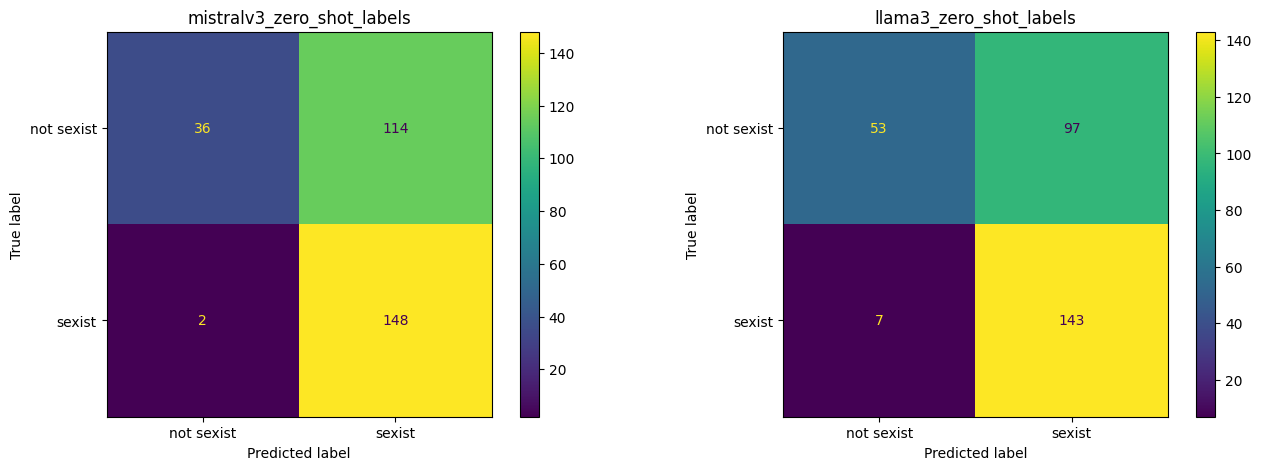

,model,accuracy,fail_ratio
7,Llama3 zero shot,0.653333,0.346667
0,Mistral v3 zero shot,0.613333,0.386667


In [ ]:
print_models_confusion_matrixs(['mistralv3_zero_shot_labels', 'llama3_zero_shot_labels'], models_predictions)

zero_shot_df = model_metrics[model_metrics['model'].str.contains('zero shot', case=False)]
zero_shot_df.sort_values('accuracy', ascending=False)

LLaMA 3 outperforms Mistral v3 in zero-shot inference.
The confusion matrix reveals that most errors made by both models involve misclassifying non-sexist tweets as sexist.

Notably, Mistral v3 misclassifies over 75% of non-sexist tweets as sexist, whereas LLaMA 3 misclassifies only 64% of non-sexist tweets as sexist.
Additionally, only a very small portion of comments classified as sexist are misclassified as non-sexist: 1.3% for Mistral v3 and 4.7% for LLaMA 3.

This discrepancy may be due to several factors. The training data might be imbalanced, with more examples of sexist comments, leading to better recognition of sexist patterns. Sexist comments could also have more distinctive linguistic features, making them easier to identify. Additionally, biases in annotation and the need for nuanced understanding of non-sexist comments might contribute to the models' difficulties.

One possible reason for the models being trained on unbalanced data is that the developers aimed to address the generation of unsuitable content. The techniques employed to prevent the generation of such content might have inadvertently led to a significant imbalance between the recognition of the two classes. This imbalance could result in the models being more adept at identifying one class over the other, thus affecting their overall performance.

In [ ]:
print_misslabeled_tweets('Mistralv3', ['mistralv3_zero_shot_labels'], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Mistralv3

Analyzing mistralv3_zero_shot_labels:
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 140) Karma's a bitch! 


In [ ]:
print_misslabeled_tweets('Llama3', ['llama3_zero_shot_labels'], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Llama3

Analyzing llama3_zero_shot_labels:
row 16) Giving women all your money is good personality. 
row 59) Greens, eh? The fateful question of the Occident is thus now whether young female university graduates can be continually served with yoga and Pilates courses even amidst the ruins looming on the horizon. 
row 75) Well said. Single mothers would not get this point. 
row 220) what have you tried already? I like to point out that nobody blinks when a smaller man starts shit with a larger man and gets his ass beat, men and women are equal right? 
row 238) Not all Blacks are complete NIGGERS like this whore The Pure POS Nigger bitch gives others a bad name fucking cunt Should investigate where she worked and deaths 
row 245) To female Bishops stop making fun of religion. 
row 249) I know mine is higher with smart women than dumb women. Or rather, it's lower with dumb women because my lack of knowledge or interest in what (Insert celeb

The comments misclassified by Mistral v3 are clearly mislabeled, whereas those misclassified by LLaMA 3 are clearly false negatives. This suggests that Mistral v3 received training that better enables it to identify sexist comments compared to LLaMA 3. This difference in performance may be attributed to the specific techniques used during training, which might have focused more on recognizing and preventing the generation of unsuitable content. Consequently, this focus could have led to an imbalance in the training data, enhancing Mistral v3's ability to detect sexist comments but also increasing the likelihood of misclassifying non-sexist comments.

### Task 6.3 - Model performance evaluation with few shot inference


In the next session, we will compare the performance of the base models with various few-shot techniques. The base model will serve as a baseline to evaluate the extent of improvements achieved through few-shot prompting. We aim to determine whether a model that performs poorly with zero-shot inference can improve when provided with a few examples in the prompt. Additionally, we will identify the most effective few-shot technique for the task of labeling comments as sexist or non-sexist. This analysis will help us understand the potential of few-shot learning in enhancing model accuracy for this specific classification task.

#### Few shot with ramdomly sampled examplse from the dataset



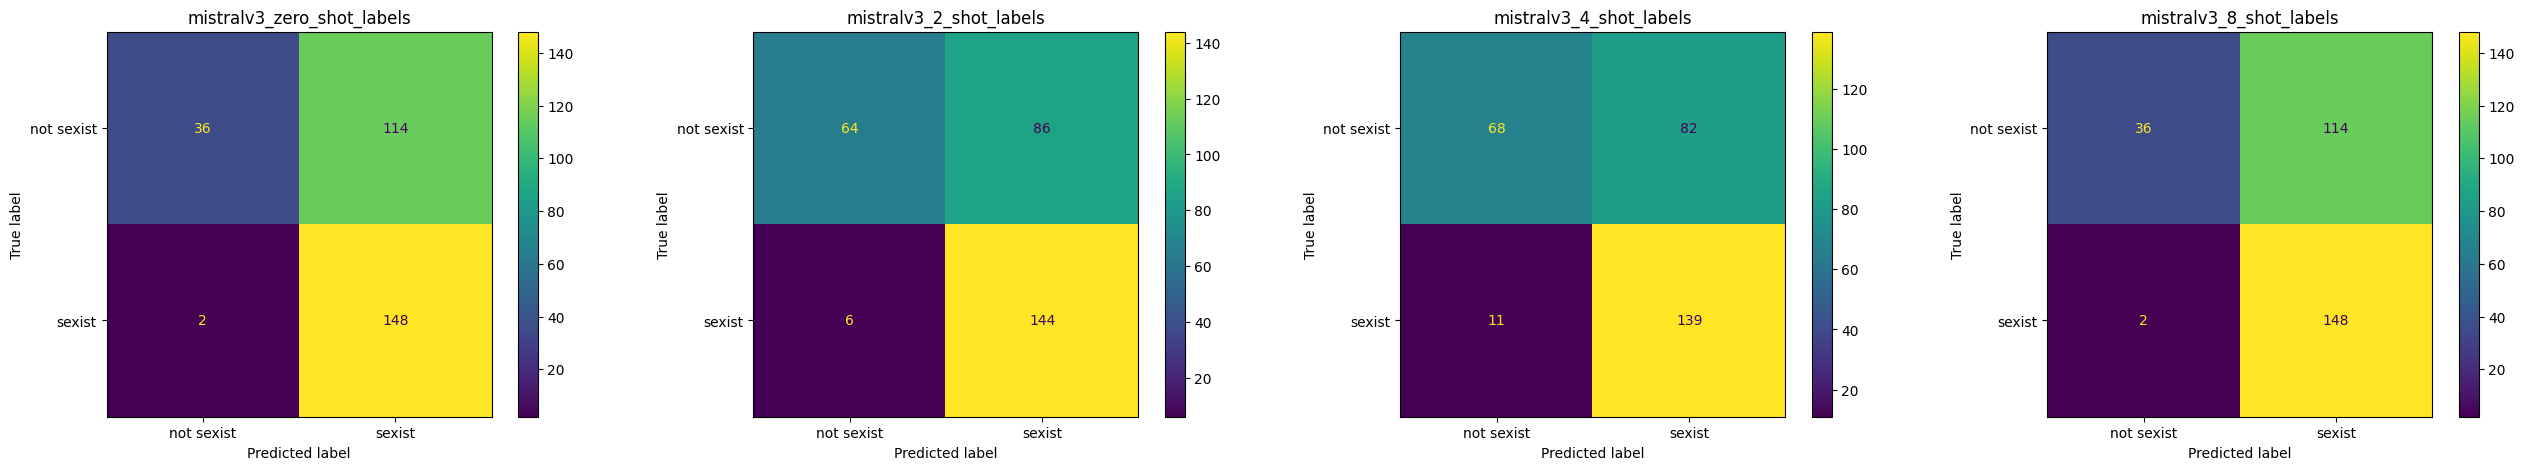

,model,accuracy,fail_ratio
1,Mistral v3 2 shot,0.693333,0.306667
2,Mistral v3 4 shot,0.690000,0.310000
0,Mistral v3 zero shot,0.613333,0.386667
3,Mistral v3 8 shot,0.613333,0.386667


In [ ]:
mistral_models_labels = ['mistralv3_zero_shot_labels', 'mistralv3_2_shot_labels', 'mistralv3_4_shot_labels', 'mistralv3_8_shot_labels']
print_models_confusion_matrixs(mistral_models_labels, models_predictions)
mistral_base_prompting =  model_metrics[model_metrics['model'].str.contains('Mistral', case=False) & ~model_metrics['model'].str.endswith('ma')]
mistral_base_prompting.sort_values('accuracy', ascending=False)

The results indicate that Mistral v3's performance improves with two-shot examples, achieving an accuracy of 0.693333 compared to the zero-shot baseline of 0.613333. However, increasing the number of examples to four or eight does not yield further improvements, with the eight-shot model performing identically to the zero-shot model.



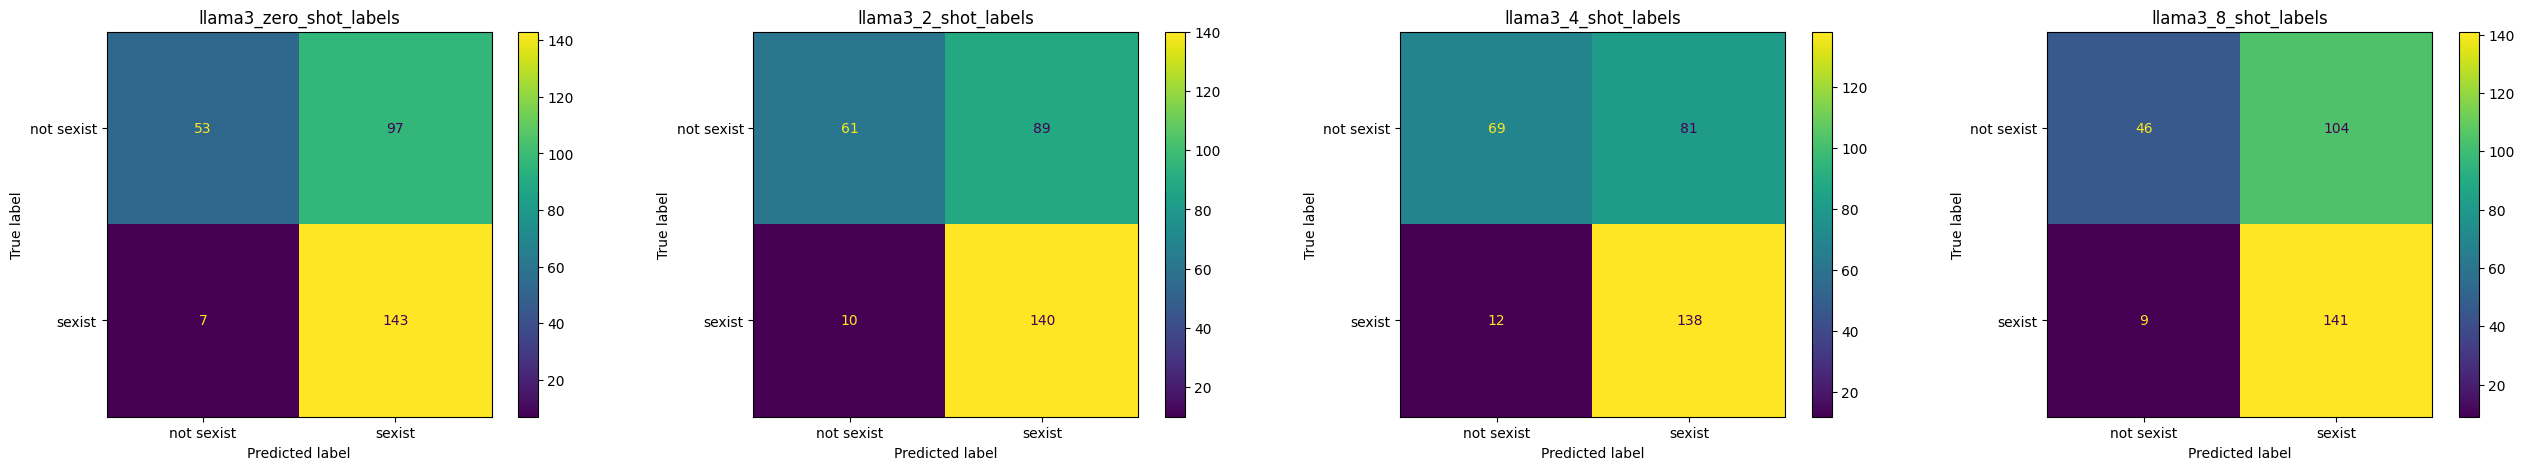

,model,accuracy,fail_ratio
9,llama3 4 shot,0.690000,0.310000
8,Llama3 2 shot,0.670000,0.330000
7,Llama3 zero shot,0.653333,0.346667
10,Llama3 8 shot,0.623333,0.376667


In [ ]:
llama_models_labels = ['llama3_zero_shot_labels', 'llama3_2_shot_labels', 'llama3_4_shot_labels', 'llama3_8_shot_labels']
print_models_confusion_matrixs(llama_models_labels, models_predictions)
llama3_base_prompting =  model_metrics[model_metrics['model'].str.contains('Llama3', case=False) & ~model_metrics['model'].str.endswith('ma')]
llama3_base_prompting.sort_values('accuracy', ascending=False)

The table shows that LLaMA 3's performance improves with two-shot and four-shot examples, achieving the highest accuracy of 0.690000 with four-shot examples. However, the eight-shot model performs worse than the zero-shot model, with a decline in accuracy to 0.623333. This suggests that while a few examples can enhance performance, too many examples can degrade it.


We suspect that the inconsistent performance in both models is due to the poor quality of the examples used in multiple-shot learning. These examples were randomly extracted from the dataset, which may have led to suboptimal training and the observed lack of improvement. It is important to note that, despite being random, the models were prompted with the same textual prompt for each respective prompting technique.

To eliminate the potential problems associated with random selection and better assess the models' performance and to verify the previus claims, we conducted another evaluation of the prompt. This time, the examples injected into the prompt were manually checked by us in order to avoid issues arising from mislabeled or non-meaningful examples.

#### Few shot with manually annotated examples in the prompt

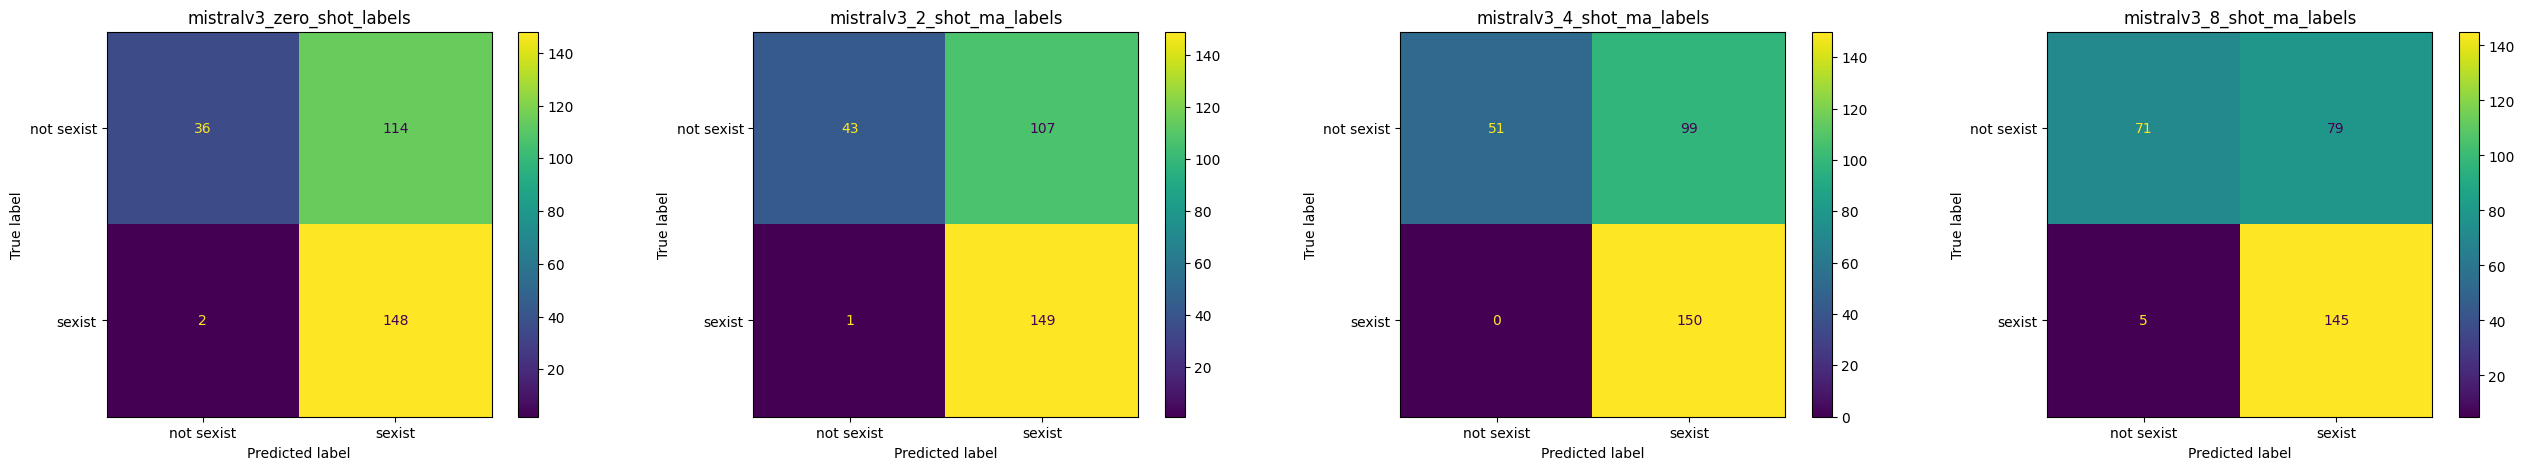

,model,accuracy,fail_ratio
6,Mistral v3 8 shot ma,0.720000,0.280000
5,Mistral v3 4 shot ma,0.670000,0.330000
4,Mistral v3 2 shot ma,0.640000,0.360000
0,Mistral v3 zero shot,0.613333,0.386667


In [ ]:
mistral_models_labels = ['mistralv3_zero_shot_labels', 'mistralv3_2_shot_ma_labels', 'mistralv3_4_shot_ma_labels', 'mistralv3_8_shot_ma_labels']
print_models_confusion_matrixs(mistral_models_labels, models_predictions)
mistral_base_prompting = model_metrics[model_metrics['model'].str.contains('Mistral', case=False) &
                                                    (model_metrics['model'].str.endswith('ma') | model_metrics['model'].str.endswith('zero shot'))]
mistral_base_prompting.sort_values('accuracy', ascending=False)

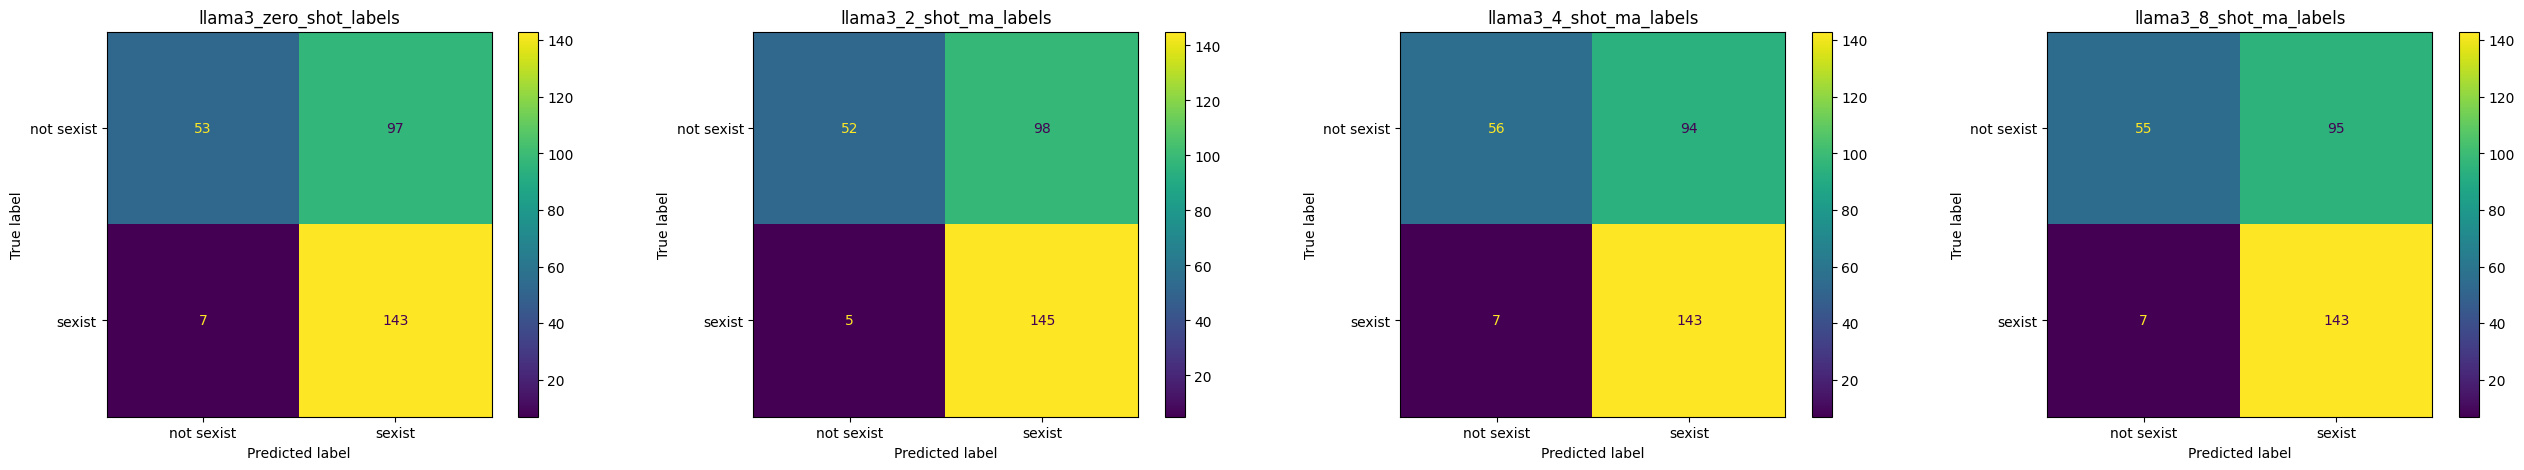

,model,accuracy,fail_ratio
12,Llama3 4 shot ma,0.663333,0.336667
13,Llama3 8 shot ma,0.660000,0.340000
11,Llama3 2 shot ma,0.656667,0.343333
7,Llama3 zero shot,0.653333,0.346667


In [42]:
llama_models_labels = ['llama3_zero_shot_labels', 'llama3_2_shot_ma_labels', 'llama3_4_shot_ma_labels', 'llama3_8_shot_ma_labels']
print_models_confusion_matrixs(llama_models_labels, models_predictions)
mistral_base_prompting = model_metrics[model_metrics['model'].str.contains('Llama3', case=False) &
                                                    (model_metrics['model'].str.endswith('ma') | model_metrics['model'].str.endswith('zero shot'))]
mistral_base_prompting.sort_values('accuracy', ascending=False)

The performance of Mistral v3 and LLaMA 3 with manually labeled examples in the prompt shows significant improvements over their zero-shot baselines. For Mistral v3, the zero-shot model has an accuracy of 0.61 and a fail ratio of 0.38. With two-shot manually labeled examples, the accuracy improves to 0.64, and further increases to 0.67 with four-shot examples. The eight-shot model achieves the highest accuracy of 0.72 and the lowest fail ratio of 0.28.

Similarly, LLaMA 3's zero-shot model has an accuracy of 0.65 and a fail ratio of 0.34. The accuracy slightly improves to 0.65 with two-shot examples and further to 0.66 with four-shot examples. The eight-shot model achieves an accuracy of 0.66, which is slightly lower than the four-shot model but still better than the zero-shot baseline.

These results confirm that manually labeled examples significantly enhance the performance of both models compared to randomly selected examples, highlighting the importance of carefully choosing the examples to be injected into the prompt.

### Task 6.4 Best prompting technique error analisys  

The objective of this section is to visualize the errors made by the two models using their best prompting techniques identified in the previous section. This analysis will help us identify the types of errors most commonly committed by the models, providing insights into areas where further improvements are needed.

We start analysing the comment misslcassified as non sexist (false negative)  

In [43]:
print_misslabeled_tweets('Mistralv3', ["mistralv3_8_shot_ma_labels"], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Mistralv3

Analyzing mistralv3_8_shot_ma_labels:
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 140) Karma's a bitch! 
row 167) I'm getting older and I can't keep doing that grind to spin plates / seek out new pussy. I want to be with a woman long term, but want to learn how to avoid this issue from getting in the way. 
row 220) what have you tried already? I like to point out that nobody blinks when a smaller man starts shit with a larger man and gets his ass beat, men and women are equal right? 
row 284) Don’t hate women I just understand the price that is paid being with them (not sex) and it’s not worth it...AT ALL. 


In [45]:
print_misslabeled_tweets('Llama3', ["llama3_4_shot_ma_labels"], misslabel_type="fn", text_limit=10)

Sexist labeled tweet classified as not sexist by Llama3

Analyzing llama3_4_shot_ma_labels:
row 8) That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support. 
row 59) Greens, eh? The fateful question of the Occident is thus now whether young female university graduates can be continually served with yoga and Pilates courses even amidst the ruins looming on the horizon. 
row 140) Karma's a bitch! 
row 167) I'm getting older and I can't keep doing that grind to spin plates / seek out new pussy. I want to be with a woman long term, but want to learn how to avoid this issue from getting in the way. 
row 220) what have you tried already? I like to point out that nobody blinks when a smaller man starts shit with a larger man and gets his ass beat, men and women are equal right? 
row 245) To female Bishops stop making fun of religion. 
row 249) I know mine is higher with smart women than dumb women. Or rather, it's

Add comment here of the false negative

In [46]:
print_misslabeled_tweets('Mistralv3', ["mistralv3_8_shot_ma_labels"], misslabel_type="fp", text_limit=10)

Not sexist labeled tweet classified as sexist by Mistralv3

Analyzing mistralv3_8_shot_ma_labels:
row 3) Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior. 
row 6) ‪Import the third world and become the third world. You won’t see feminists protesting about this. ‬ ‪[URL] 
row 10) The black African will soon be labeling her a racist. Race card coming soon 
row 26) Good - the grid girls can finally get back into F1 
row 32) Before I decided to sack Twitter off entirely, I muted about 100 terms, things like Feminism, sexism, racism, Trump, Brexit. Massive fucking list. Made Twitter so much more fun. 
row 34) I'm his first ever girlfriend Incels do not get girlfriends ever 
row 38) Yes, let's all be LECTURED by a Jack-ass like this Jimbo Bono's Bud in Red #BoycottedOscars #BoycottHollywood 
row 44) They are just so pissed off cuz no woman wants neither one of them an

In [48]:
print_misslabeled_tweets('Llama3', ["llama3_4_shot_ma_labels"], misslabel_type="fp", text_limit=10)

Not sexist labeled tweet classified as sexist by Llama3

Analyzing llama3_4_shot_ma_labels:
row 2) Old man mogs everyone in this sub 
row 3) Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior. 
row 6) ‪Import the third world and become the third world. You won’t see feminists protesting about this. ‬ ‪[URL] 
row 7) Most women find a highly educated and well traveled man sexy. 
row 10) The black African will soon be labeling her a racist. Race card coming soon 
row 14) The queen is not representing herself and a direct descendant of Muhammad & high up in the Catholic church of the illuminati ... so are you surprised about this abuse of children? 
row 17) Na he's not flirting with her so she's reading him as gay. 
row 26) Good - the grid girls can finally get back into F1 
row 34) I'm his first ever girlfriend Incels do not get girlfriends ever 
row 38) Yes, let's a

# Task 7 - Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End